
# NetCDF to dfs2

## Weather forcing

The first example uses data from ECMWF ERA5 obtained from [CDS](https://cds.climate.copernicus.eu/#!/home)

A common format for multidimensional data is [NetCDF](https://www.unidata.ucar.edu/software/netcdf/).

An excellent python package for working with NetCDF in Python is [Xarray](http://xarray.pydata.org/en/stable/).

To work with NetCDF data first we need to install the `netcdf4` and `xarray` packages!  

Opening a NetCDF file with Xarray returns an `xarray.Dataset`

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import mikeio

ds = xr.open_dataset("./era5_small.nc")
ds

<xarray.Dataset> Size: 10MB
Dimensions:    (longitude: 121, latitude: 121, time: 12)
Coordinates:
  * longitude  (longitude) float32 484B 0.0 0.25 0.5 0.75 ... 29.5 29.75 30.0
  * latitude   (latitude) float32 484B 70.0 69.75 69.5 69.25 ... 40.5 40.25 40.0
  * time       (time) datetime64[ns] 96B 1977-12-01 ... 1977-12-03T18:00:00
Data variables:
    u10        (time, latitude, longitude) float64 1MB ...
    v10        (time, latitude, longitude) float64 1MB ...
    d2m        (time, latitude, longitude) float64 1MB ...
    t2m        (time, latitude, longitude) float64 1MB ...
    msl        (time, latitude, longitude) float64 1MB ...
    sp         (time, latitude, longitude) float64 1MB ...
    tcc        (time, latitude, longitude) float64 1MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-09-21 06:03:31 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

One of the datam variables is the t2m (Air temperature at 2m above the ground) which we can access in two different ways:

1. Using the string "t2m"
2. Or as a property of the Dataset object `.t2m`

In [3]:
ds["t2m"]

<xarray.DataArray 't2m' (time: 12, latitude: 121, longitude: 121)> Size: 1MB
[175692 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float32 484B 0.0 0.25 0.5 0.75 ... 29.5 29.75 30.0
  * latitude   (latitude) float32 484B 70.0 69.75 69.5 69.25 ... 40.5 40.25 40.0
  * time       (time) datetime64[ns] 96B 1977-12-01 ... 1977-12-03T18:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature

In [4]:
ds.t2m

<xarray.DataArray 't2m' (time: 12, latitude: 121, longitude: 121)> Size: 1MB
[175692 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float32 484B 0.0 0.25 0.5 0.75 ... 29.5 29.75 30.0
  * latitude   (latitude) float32 484B 70.0 69.75 69.5 69.25 ... 40.5 40.25 40.0
  * time       (time) datetime64[ns] 96B 1977-12-01 ... 1977-12-03T18:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature

To select the first timestep, we can use the `xarray.Dataset.isel` method.

In [5]:
ds0 = ds.isel(time=0)
ds0

<xarray.Dataset> Size: 821kB
Dimensions:    (longitude: 121, latitude: 121)
Coordinates:
  * longitude  (longitude) float32 484B 0.0 0.25 0.5 0.75 ... 29.5 29.75 30.0
  * latitude   (latitude) float32 484B 70.0 69.75 69.5 69.25 ... 40.5 40.25 40.0
    time       datetime64[ns] 8B 1977-12-01
Data variables:
    u10        (latitude, longitude) float64 117kB ...
    v10        (latitude, longitude) float64 117kB ...
    d2m        (latitude, longitude) float64 117kB ...
    t2m        (latitude, longitude) float64 117kB ...
    msl        (latitude, longitude) float64 117kB ...
    sp         (latitude, longitude) float64 117kB ...
    tcc        (latitude, longitude) float64 117kB ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-09-21 06:03:31 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

The dataset from the first timestep is also a Dataset, except it no longer has a time dimension.

To plot a map of the air temperature we can use select the `t2m` property and call the plot method.

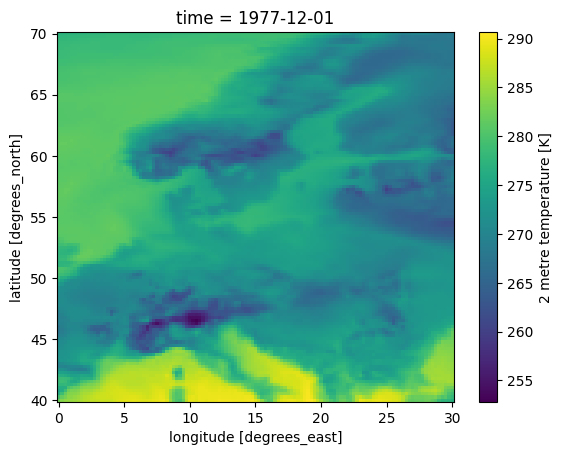

In [6]:
ds0.t2m.plot()

## Pressure

Atmospheric pressure comes in different flavors.

`Surface pressure` (sp) is the pressure at ground level, i.e. following the terrain.

In the following plot you can clearly see the decrease in surface pressure with altitude in areas with mountains.

This is *NOT* the variable used by MIKE 21 FM HD.

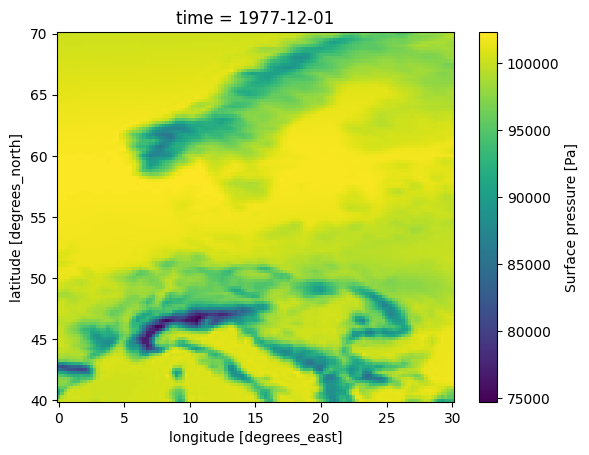

In [7]:
ds0.sp.plot()

MIKE 21 FM HD expects the atmospheric pressure reduced to Mean Sea Level. (`msl`) 

In the following plot the pressure field has a much smaller range, since the variation with altitude have been removed.

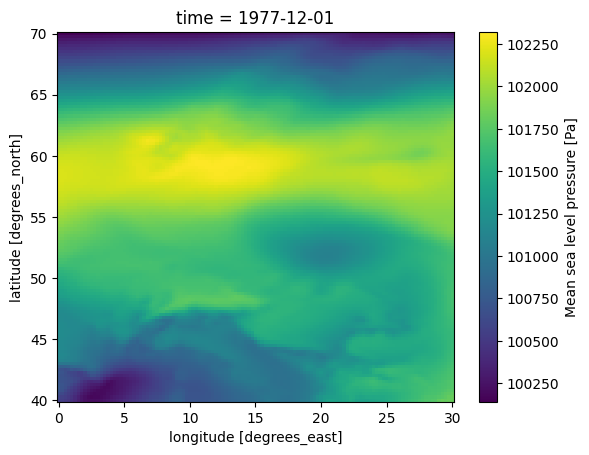

In [8]:
ds0.msl.plot()

## Wind

The wind velocity components U,V at 10m above the ground, are found in the two data variables, `u10` and `v10`

In [9]:
ds0.u10.long_name

'10 metre U wind component'

In [10]:
ds0.v10.long_name

'10 metre V wind component'

## Convert to dfs2

### Sub-region

In this case the NetCDF file covers a much larger area, than is required for our modelling work, so first step is to create a spatial subset to match our Area of Interest.

Since the latitude dimension is ordered in decreasing order in this dataset, the slice has to go from high to low.

In [11]:
ds_aoi = ds.sel(longitude=slice(10,30), 
                latitude=slice(60,45)) # N -> S
ds_aoi

<xarray.Dataset> Size: 3MB
Dimensions:    (longitude: 81, latitude: 61, time: 12)
Coordinates:
  * longitude  (longitude) float32 324B 10.0 10.25 10.5 ... 29.5 29.75 30.0
  * latitude   (latitude) float32 244B 60.0 59.75 59.5 59.25 ... 45.5 45.25 45.0
  * time       (time) datetime64[ns] 96B 1977-12-01 ... 1977-12-03T18:00:00
Data variables:
    u10        (time, latitude, longitude) float64 474kB ...
    v10        (time, latitude, longitude) float64 474kB ...
    d2m        (time, latitude, longitude) float64 474kB ...
    t2m        (time, latitude, longitude) float64 474kB ...
    msl        (time, latitude, longitude) float64 474kB ...
    sp         (time, latitude, longitude) float64 474kB ...
    tcc        (time, latitude, longitude) float64 474kB ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-09-21 06:03:31 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

Make a plot to check that the area is the one we expect.

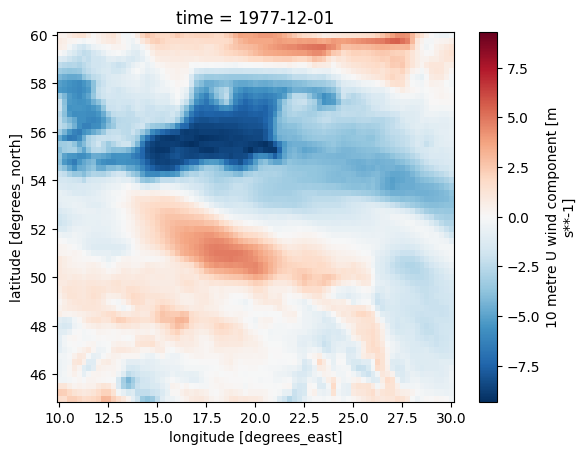

In [13]:
ds_aoi.isel(time=0).u10.plot();

### Time

Now we are ready to convert this data to dfs2.

First step is to create a time axis, which can be understood by MIKE IO.

In [14]:
time = pd.DatetimeIndex(ds.time)
time

DatetimeIndex(['1977-12-01 00:00:00', '1977-12-01 06:00:00',
               '1977-12-01 12:00:00', '1977-12-01 18:00:00',
               '1977-12-02 00:00:00', '1977-12-02 06:00:00',
               '1977-12-02 12:00:00', '1977-12-02 18:00:00',
               '1977-12-03 00:00:00', '1977-12-03 06:00:00',
               '1977-12-03 12:00:00', '1977-12-03 18:00:00'],
              dtype='datetime64[ns]', freq=None)

Then create the spatial axis

In [15]:
g = mikeio.Grid2D(x=ds_aoi.longitude, y=ds_aoi.latitude[::-1], projection="LONG/LAT")
g

<mikeio.Grid2D>
x: [10, 10.25, ..., 30] (nx=81, dx=0.25)
y: [45, 45.25, ..., 60] (ny=61, dy=0.25)
projection: LONG/LAT

The next step is to collect the variables that we need, and at the same time do unit conversion where it is necessary. In this case for pressure and temperature.

In [16]:
das = [
    mikeio.DataArray(np.flip(ds_aoi.msl.values, axis=1) / 100.0,
                     time=time, geometry=g,
                     item=mikeio.ItemInfo("MSLP", mikeio.EUMType.Pressure, mikeio.EUMUnit.hectopascal)),
    
    mikeio.DataArray(np.flip(ds_aoi.u10.values, axis=1),
                     time=time, geometry=g,
                     item=mikeio.ItemInfo("U 10m", mikeio.EUMType.Wind_Velocity, mikeio.EUMUnit.meter_per_sec)),
    
    mikeio.DataArray(np.flip(ds_aoi.v10.values, axis=1), 
                     time=time, geometry=g, 
                     item=mikeio.ItemInfo("V 10m", mikeio.EUMType.Wind_Velocity, mikeio.EUMUnit.meter_per_sec)),
    
    mikeio.DataArray(np.flip(ds_aoi.t2m.values, axis=1) - 273.15,
                     time=time, geometry=g,
                     item=mikeio.ItemInfo("Temperature", mikeio.EUMType.Temperature, mikeio.EUMUnit.degree_Celsius))
]

In [17]:
my_ds = mikeio.Dataset(das)
my_ds

<mikeio.Dataset>
dims: (time:12, y:61, x:81)
time: 1977-12-01 00:00:00 - 1977-12-03 18:00:00 (12 records)
geometry: Grid2D (ny=61, nx=81)
items:
  0:  MSLP <Pressure> (hectopascal)
  1:  U 10m <Wind Velocity> (meter per sec)
  2:  V 10m <Wind Velocity> (meter per sec)
  3:  Temperature <Temperature> (degree Celsius)

Let's plot to confirm that it looks alright

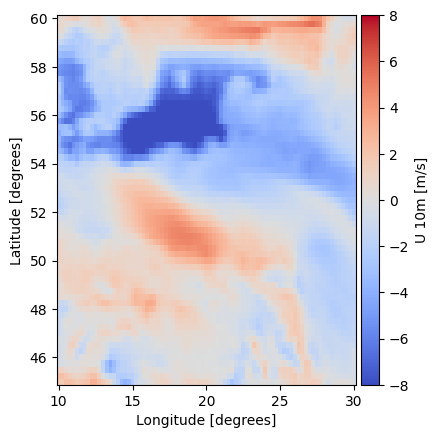

In [18]:
my_ds.U_10m.plot(cmap="coolwarm",vmin=-8,vmax=8);

The dimensions for at  DFS2 are expected to be (t, y, x), which matches the ones used by this dataset.

This convention is recommended by the [CF convention](http://cfconventions.org/cf-conventions/cf-conventions.html#dimensions)

In [19]:
ds.Conventions

'CF-1.6'

In [20]:
ds.u10.dims

('time', 'latitude', 'longitude')

In [21]:
my_ds.dims

('time', 'y', 'x')

The final step is to write the dataset to a dfs2 file. The Dataset already contains all the information needed.

In [22]:
my_ds.to_dfs("era5_aoi.dfs2")


Screenshot of U 10m from MIKE Zero

![](images/era5_u10_dfs2.png)